In [1]:
import numpy as np
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp, Statevector
from tabulate import tabulate
from itertools import combinations
from qiskit.circuit.library import EfficientSU2
import math
import time
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.time_evolvers.variational import ImaginaryMcLachlanPrinciple
from qiskit.algorithms import TimeEvolutionProblem
from qiskit.algorithms import VarQITE
from qiskit.primitives import Estimator
from qiskit.quantum_info import Statevector
from qiskit.algorithms import SciPyImaginaryEvolver
import pylab
from qiskit.algorithms.gradients import ReverseEstimatorGradient, ReverseQGT
from qiskit.circuit.library import RYGate
import matplotlib.pyplot as plt

In [2]:
def tb0_JW(N,e,t) : 
    strings = []
    opt = SparsePauliOp.from_sparse_list([("I", [0], 0)], num_qubits=N)  
    for k in range(N) : 
        a0='I'*(N)
        a1 = 'I'*(k)+'Z' +'I'*(N-k-1)

        b0='I'*N
        b0_list = list(b0)
        b0_list[k] = 'X'
        b0_list[(k+1)%N] = 'X'
        new_b0 = ''.join(b0_list)

        b1='I'*N
        b1_list = list(b0)
        b1_list[k] = 'Y'
        b1_list[(k+1)%N] = 'Y'
        new_b1 = ''.join(b1_list)

        strings.append([a0,a1,new_b0,new_b1])
        val = 1
        if N==2 and k==1 : 
            val = 0
        opt += SparsePauliOp.from_list([(a0, 0.5*e[k]), (a1, -0.5*e[k]),(new_b0, 0.5*t*val),(new_b1, 0.5*t*val)])
    return opt  

def spinless_basis(N,r) : 
    basis_set = []
    lattice = list(range(N))
    places = list(combinations(lattice, r))
    for combination in places : 
        basis = [False] *N
        for index in combination : 
            basis[index] = True 
        basis_set.append(basis)
    return basis_set

In [5]:
N=3
e=[1]*N
t=7
H_op = tb0_JW(N,e,t)

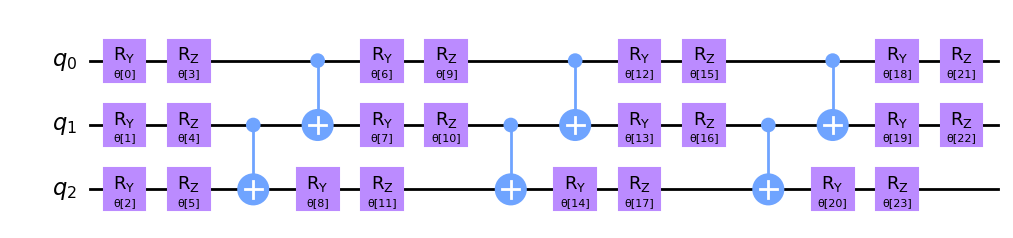

In [6]:
su2 = EfficientSU2(H_op.num_qubits, reps=3)
su2.decompose().draw('mpl')

In [7]:
def scs_param(n,l,var,param) : 

    circ = QuantumCircuit(n)
    circ.cx(-2,-1)
    circ.cry(param[var],-1,-2)
    var+=1
    circ.cx(-2,-1)

    for i in range(l-1) : 
        circ.cx(-3-i,-1)
        ccry = RYGate(param[var]).control(2,label=None)
        var+=1
        circ.append(ccry,[-1,-2-i,-3-i])
        circ.cx(-3-i,-1)
    return circ, var

def dicke_param(n,k) : 
    pairs = []
    for a in range(n,k,-1) : 
        pairs.append([a,k])
    for a in range(k,1,-1) : 
        pairs.append([a,a-1])

    num_angles = int(k*(n-k) + k*(k-1)/2)
    param = [Parameter(f"angle_{i+1}") for i in range(num_angles)]

    dk_circ = QuantumCircuit(n)
    dk_circ.x(range(-1,-k-1,-1))
    var=0
    for pair in pairs : 
        new_circ,new_var = scs_param(pair[0],pair[1],var,param)
        var = new_var
        dk_circ.append(new_circ, range(pair[0]))
    return dk_circ

In [8]:
eig,vec = np.linalg.eig(H_op.to_matrix())
new_vec = list(zip(*vec))

In [9]:
print(eig)
eigstates = []
for i,x in enumerate(eig) : 
    if np.round(x) == np.round(min(eig)) : 
        eigstates.append(new_vec[i])
print(min(eig))
for state in eigstates : 
    print([np.round(x,3) for x in np.asarray(state)])
    print(state)

[-5.+0.j 16.+0.j -6.+0.j 15.+0.j -6.+0.j -5.+0.j  0.+0.j  3.+0.j]
(-6.000000000000002+0j)
[0j, (0.816+0j), (-0.408+0j), (-0+0j), (-0.408+0j), (-0+0j), 0j, 0j]
(0j, (0.8164965809277259+0j), (-0.40824829046386313+0j), (-3.4773049747630503e-16+0j), (-0.40824829046386324+0j), (-3.4773049747630503e-16+0j), (7.062870672917815e-16+0j), 0j)
[0j, (-0.063+0j), (-0.673+0j), 0j, (0.737+0j), (-0+0j), (-0+0j), 0j]
(0j, (-0.06303746302323883+0j), (-0.6734775157774674+0j), (2.482283250838288e-16+0j), (0.7365149788007062+0j), (-1.9453539142375413e-16+0j), (-5.452875851312181e-17+0j), 0j)


{Parameter(angle_1): 1, Parameter(angle_2): 1}
Elapsed time:  0.5249471664428711  seconds for ansatz a_i = 0
Rounded statevector : 
[(-0+0j), (0.087+0j), (0.457+0j), 0j, (-0.885+0j), (-0+0j), 0j, (-0+0j)]
Overlap with exact statevector =  [(0.24576547085924566+0j), (-0.9650792402319494+0j)]
Estimated Lowest Eigenvalue = -5.186994734483555
Exact lowest eigenvalue found :  -6.0
error = 0.8130052655164466


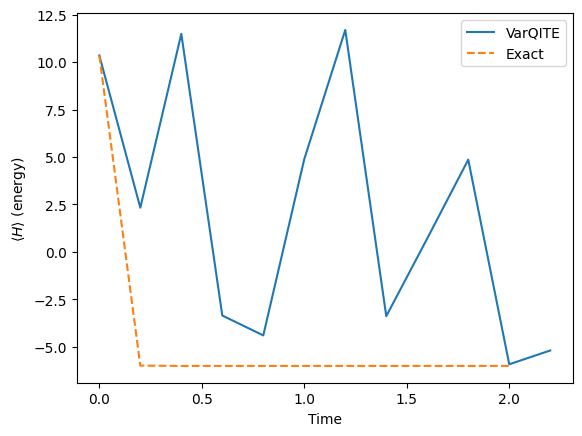

In [10]:
ansatz_list = [su2,dicke_param(N,N//2)]
ansatz_list = [su2]
ansatz_list = [dicke_param(N,N//2)]
backend = Aer.get_backend('statevector_simulator')

for a_i,ansatz in enumerate(ansatz_list) : 
    init_param_values={}
    for i in range(len(ansatz.parameters)):
        init_param_values[ansatz.parameters[i]]=1
    print(init_param_values)
    
    #var_principle = ImaginaryMcLachlanPrinciple()
    exp_time = 2.0
    num_steps = 10
    aux_ops = [H_op]
    evolution_problem = TimeEvolutionProblem(H_op, exp_time, aux_operators=aux_ops)
    
    start_time = time.time()
    var_principle = ImaginaryMcLachlanPrinciple(qgt = ReverseQGT() , gradient = ReverseEstimatorGradient())
    evolution_problem = TimeEvolutionProblem(H_op, exp_time, aux_operators=aux_ops)
    var_qite = VarQITE(ansatz, init_param_values, var_principle, Estimator(),
                       num_timesteps=num_steps)
    evolution_result_eff = var_qite.evolve(evolution_problem)
    end_time = time.time()
    elapsed_time = end_time - start_time

    print("Elapsed time: ", elapsed_time, " seconds for ansatz a_i =",a_i)
    
    eff_circ = evolution_result_eff.evolved_state
    
    eff_job = execute(eff_circ, backend)
    eff_result = eff_job.result()
    eff_statevector = eff_result.get_statevector()
    
    sum_of_squares = (np.array(eff_statevector).conj() @ np.array(eff_statevector)).real
    norm_state = eff_statevector/np.sqrt(sum_of_squares)
    final_sv = [np.round(x,3) for x in np.asarray(norm_state)]
    print("Rounded statevector : ")
    print(final_sv)
    
    overlap_list =[]
    for state in eigstates : 
        overlap_list.append((np.dot(state,np.conj(final_sv))))
    print("Overlap with exact statevector = ",overlap_list)
    
    h_exp_val = np.array([ele[0][0] for ele in evolution_result_eff.observables])
    print("Estimated Lowest Eigenvalue =", h_exp_val[-1])
    
    #Classical simulation
    init_state = Statevector(ansatz.assign_parameters(init_param_values))
    
    evolution_problem = TimeEvolutionProblem(H_op, exp_time, initial_state=init_state, 
                                             aux_operators=aux_ops)
    exact_evol = SciPyImaginaryEvolver(num_timesteps=num_steps)
    sol = exact_evol.evolve(evolution_problem)
    
    exact_h_exp_val = sol.observables[0][0].real
    print("Exact lowest eigenvalue found : ",exact_h_exp_val[-1]) 
    
    print('error =', np.abs(min(eig)-h_exp_val[-1]))
    times_eff = evolution_result_eff.times
    times_exact = sol.times
    pylab.plot(times_eff, h_exp_val, label= "VarQITE")
    pylab.plot(times_exact, exact_h_exp_val , label= "Exact",  linestyle='--')
    pylab.xlabel("Time")
    pylab.ylabel(r"$\langle H \rangle$ (energy)")
    pylab.legend(loc="upper right");
    plt.pause(1)


In [39]:
# import numpy as np

# # Two sample complex state vectors as lists or arrays
# state_vector_A = [1 + 2j, 3 - 1j, 2 + 2j]
# state_vector_B = [0 + 1j, 2 + 2j, 1 - 1j]

# # Convert the lists to complex NumPy arrays
# state_vector_A = np.array(state_vector_A, dtype=np.complex)
# state_vector_B = np.array(state_vector_B, dtype=np.complex)

# # Calculate the dot product using np.vdot() for complex conjugate dot product
# dot_product = np.vdot(state_vector_A, state_vector_B)

# print("Dot Product:", dot_product)


In [40]:
# plain = QuantumCircuit(N)
# bool_basis = spinless_basis(N,N//2)

# initial_vec = [0]*(2**N)
# #print(initial_vec)
# vec_index = []
# for vec in bool_basis : 
#     new_vec = [2**(N-i-1)*x for i,x in enumerate(vec)]
#     vec_index.append(sum(new_vec))
# #print(vec_index)
# for index in vec_index : 
#     initial_vec[index] = 1/np.sqrt(math.comb(N,N//2))

# #print(initial_vec)
# plain.initialize(initial_vec)

In [41]:
# easy = QuantumCircuit(N)
# param = Parameter("theta")
# easy.ry(param,0)
# easy.cx(0,1)
# easy.x(1)
# #print(easy)
# print(easy.parameters)
# ansatz=easy
# easy.draw('mpl')

In [42]:
# easy3 = QuantumCircuit(3)
# param = [Parameter("a_0"),Parameter("a_1"),Parameter("a_2") ]
# easy3.ry(param[0],0)
# easy3.cx(0,1)
# easy3.cry(param[1],0,2)
# easy3.x(1)
# easy3.ry(param[2],1)
# ansatz=easy3
# easy3.draw('mpl')

In [43]:
ansatz = dicke_param(N,1)
init_param_values={}
for i in range(len(ansatz.parameters)):
    init_param_values[ansatz.parameters[i]]=1
print(init_param_values)

{Parameter(angle_1): 1, Parameter(angle_2): 1, Parameter(angle_3): 1, Parameter(angle_4): 1, Parameter(angle_5): 1}


In [44]:
# print(sum([x**2 for x in initial_vec]))

In [ ]:
# from qiskit.algorithms.time_evolvers.variational import ImaginaryMcLachlanPrinciple

var_principle = ImaginaryMcLachlanPrinciple()

In [ ]:
# from qiskit.algorithms import TimeEvolutionProblem

exp_time = 5.0
aux_ops = [H_op]
evolution_problem = TimeEvolutionProblem(H_op, exp_time, aux_operators=aux_ops)

In [ ]:
backend = Aer.get_backend('statevector_simulator')

In [ ]:
#from qiskit.algorithms.gradients import ReverseEstimatorGradient, ReverseQGT
start_time = time.time()
var_principle = ImaginaryMcLachlanPrinciple(qgt = ReverseQGT() , gradient = ReverseEstimatorGradient())
evolution_problem = TimeEvolutionProblem(H_op, exp_time, aux_operators=aux_ops)
var_qite = VarQITE(ansatz, init_param_values, var_principle, Estimator())
evolution_result_eff = var_qite.evolve(evolution_problem)
end_time = time.time()
elapsed_time = end_time - start_time

print("Elapsed time: ", elapsed_time, " seconds")

In [ ]:
eff_circ = evolution_result_eff.evolved_state

In [19]:
eff_job = execute(eff_circ, backend)
eff_result = eff_job.result()
eff_statevector = eff_result.get_statevector()

print(eff_statevector)


Statevector([ 0.00000000e+00+0.j, -4.71947371e-01+0.j, -3.41043870e-01+0.j,
              0.00000000e+00+0.j,  8.12991241e-01+0.j,  0.00000000e+00+0.j,
              0.00000000e+00+0.j,  3.26053227e-17+0.j],
            dims=(2, 2, 2))


In [20]:
final_sv = [np.round(x,3) for x in np.asarray(eff_statevector)]

print(final_sv)

[0j, (-0.472+0j), (-0.341+0j), 0j, (0.813+0j), 0j, 0j, 0j]


In [21]:
print(evolution_result_eff)

{   'aux_ops_evaluated': [(-5.999999999999998, {})],
    'evolved_state': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000167767658E0>,
    'observables': [   [(10.34705854889094, {})],
                       [(8.776798563262863, {})],
                       [(6.932974868835024, {})],
                       [(4.929193584970815, {})],
                       [(2.94342083458492, {})],
                       [(1.112144663712649, {})],
                       [(-0.6731736699997675, {})],
                       [(-2.3165081118849313, {})],
                       [(-3.5238528909144753, {})],
                       [(-4.370838084053885, {})],
                       [(-4.946554287773955, {})],
                       [(-5.327182270458367, {})],
                       [(-5.573839063943574, {})],
                       [(-5.731531888729265, {})],
                       [(-5.831461164694999, {})],
                       [(-5.894427992537831, {})],
                       [(-5.933961913

In [22]:
h_exp_val = np.array([ele[0][0] for ele in evolution_result_eff.observables])
h_exp_val[-1]

-5.999999999999998

In [23]:
# # import pylab

# h_exp_val = np.array([ele[0][0] for ele in evolution_result_eff.observables])

# #exact_h_exp_val = sol.observables[0][0].real

# times = evolution_result_eff.times
# pylab.plot(times, h_exp_val, label= "VarQITE")
# #pylab.plot(times, exact_h_exp_val , label= "Exact",  linestyle='--')
# pylab.xlabel("Time")
# pylab.ylabel(r"$\langle H \rangle$ (energy)")
# pylab.legend(loc="upper right");

In [24]:
# for n in range(2,11) : 
#     print("N=",n)
#     print(math.comb(n,n//2))
#     print(2**n)
#     print('--------')

In [25]:
init_state = Statevector(ansatz.assign_parameters(init_param_values))

In [26]:
# from qiskit.algorithms import SciPyImaginaryEvolver

evolution_problem = TimeEvolutionProblem(H_op, exp_time, initial_state=init_state, aux_operators=aux_ops)
exact_evol = SciPyImaginaryEvolver(num_timesteps=501)
sol = exact_evol.evolve(evolution_problem)

In [27]:
exact_h_exp_val = sol.observables[0][0].real
exact_h_exp_val[-1]

-6.000000000000002

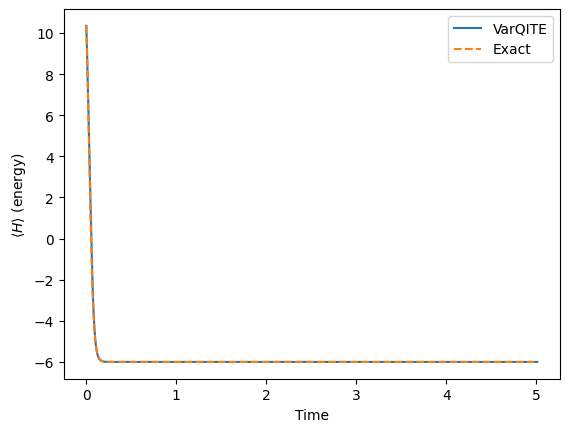

In [28]:
times = evolution_result_eff.times
pylab.plot(times, h_exp_val, label= "VarQITE")
pylab.plot(times, exact_h_exp_val , label= "Exact",  linestyle='--')
pylab.xlabel("Time")
pylab.ylabel(r"$\langle H \rangle$ (energy)")
pylab.legend(loc="upper right");

In [ ]:
2 - 1 
3 - 1 
4 - 3 
5 - 3 (0.08 error)
6 - 3 (1.5)
